Imports and Initialization

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
import matplotlib.pyplot as plt
# we can use the LabelEncoder to encode the gender feature
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# importing two different imputation methods that take into consideration all the features when predicting the missing values
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn.dummy import DummyClassifier

# oversample the minority class using SMOTE
#from imblearn.over_sampling import SMOTE
from collections import Counter

np.random.seed(42)

#### Data Summarization

Line graphs of all key indicators over time

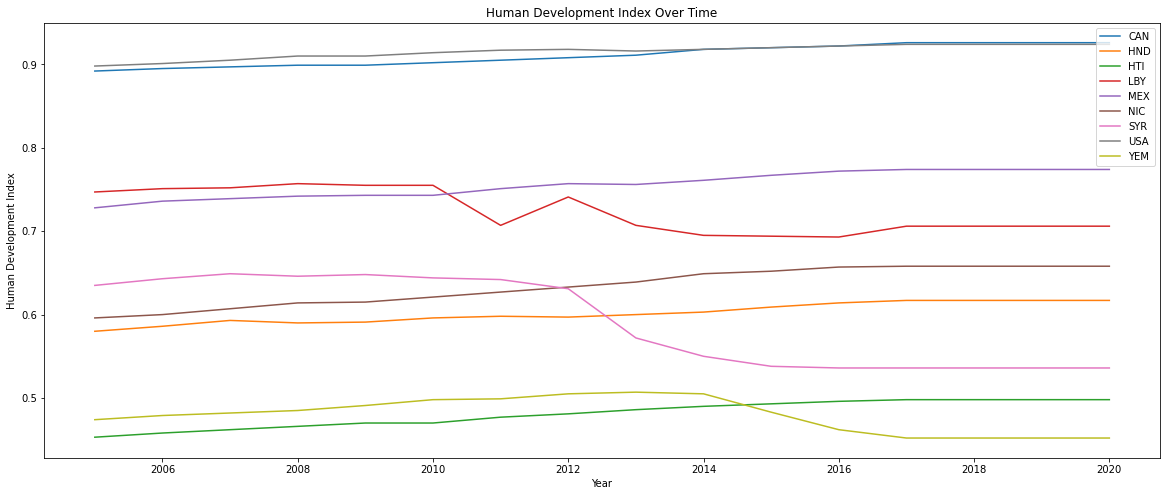

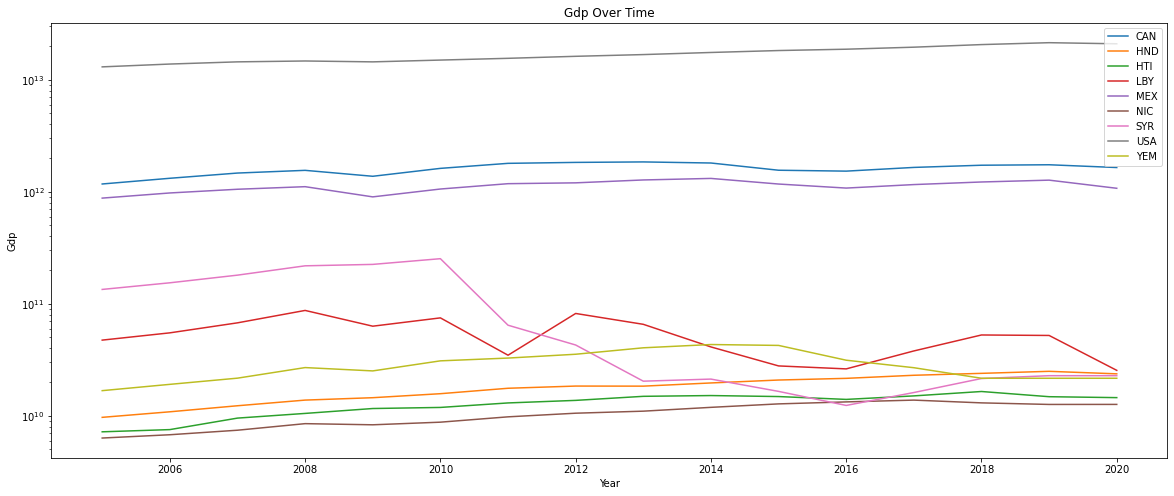

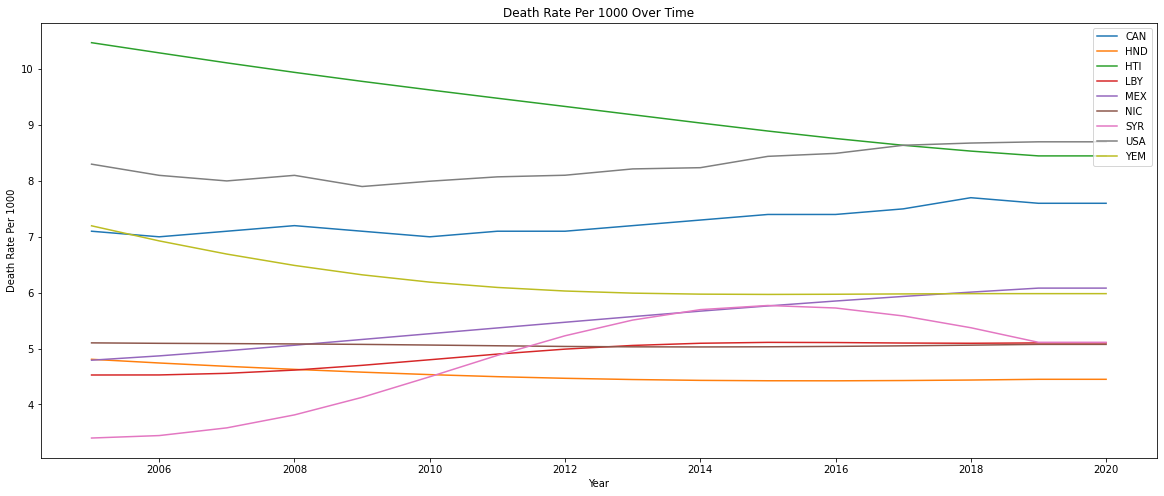

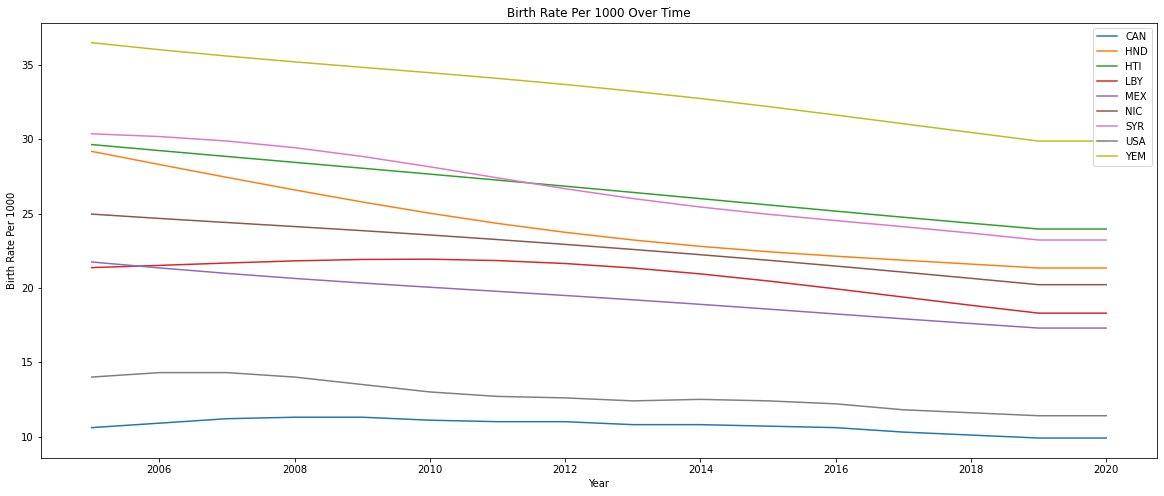

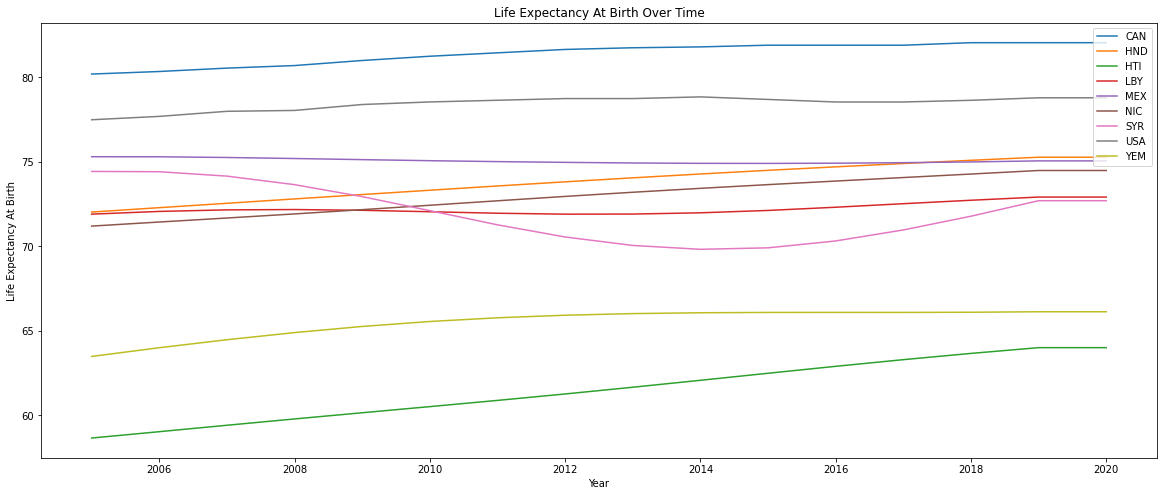

In [21]:
keyIndicators = pd.read_csv("data/key_indicators")

countryCodes = [
    'CAN',
    'HND',
    'HTI',
    'LBY',
    'MEX',
    'NIC',
    'SYR',
    'USA',
    'YEM'
]

facts = ['human_development_index','gdp','death_rate_per_1000','birth_rate_per_1000','life_expectancy_at_birth']

for fact in facts:
    columnLbl = fact.replace("_", " ").title()

    fig, ax = plt.subplots(figsize=(20, 8))

    # Iterate through the countries and show the key indicator over time
    for key, group in keyIndicators.groupby(['country_code']):
        ax = group.plot(logy=(fact == 'gdp'), ax=ax, kind='line', x='yr', y=fact, label=str(key)) # increase clarity of label    
        
    # The labels are used to define the legend. Move the legend to the upper right.    
    plt.legend(loc='upper right')

    # Define the name of the axes.
    plt.xlabel("Year")
    plt.ylabel(columnLbl)

    # Title the figure.
    plt.title(columnLbl + " Over Time")

    # Plot the figure
    plt.show()

Scatter Plot of Attributes vs Human Development Index (HDI)

gdp


Text(0.5, 0, 'Attribute')

Text(0, 0.5, 'Human Development Index (HDI)')

Text(0.5, 1.0, 'Attribute vs HDI')

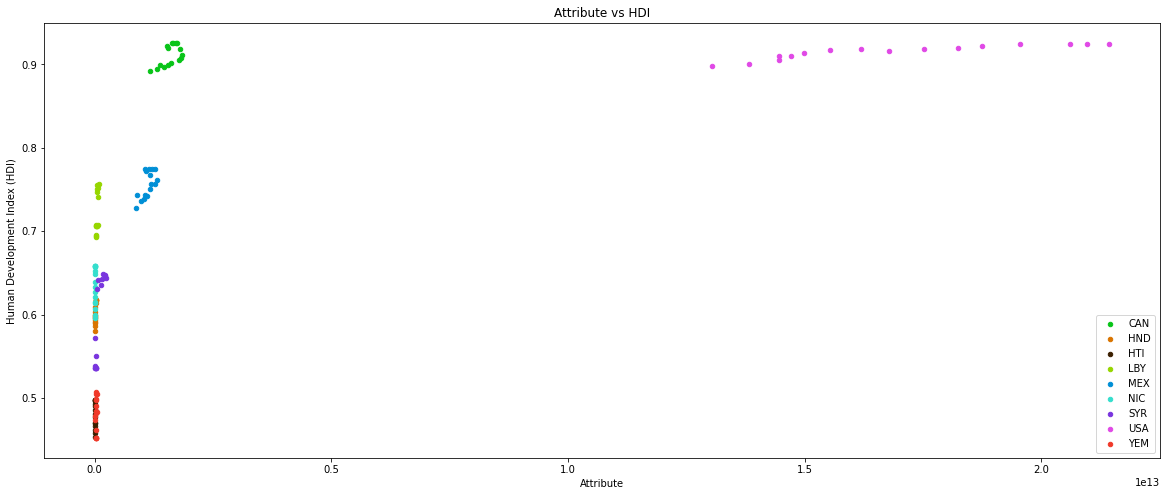

death_rate_per_1000


Text(0.5, 0, 'Attribute')

Text(0, 0.5, 'Human Development Index (HDI)')

Text(0.5, 1.0, 'Attribute vs HDI')

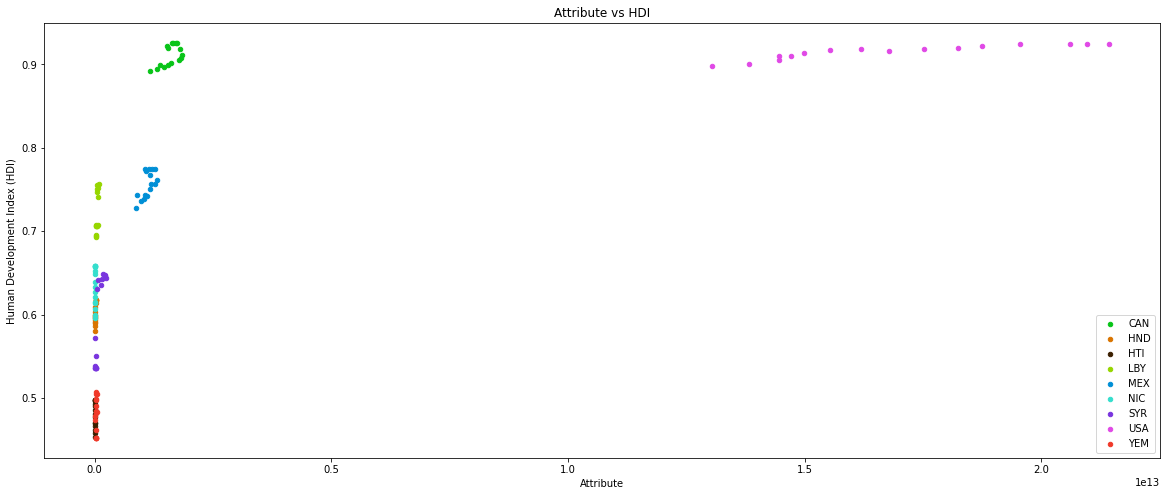

birth_rate_per_1000


Text(0.5, 0, 'Attribute')

Text(0, 0.5, 'Human Development Index (HDI)')

Text(0.5, 1.0, 'Attribute vs HDI')

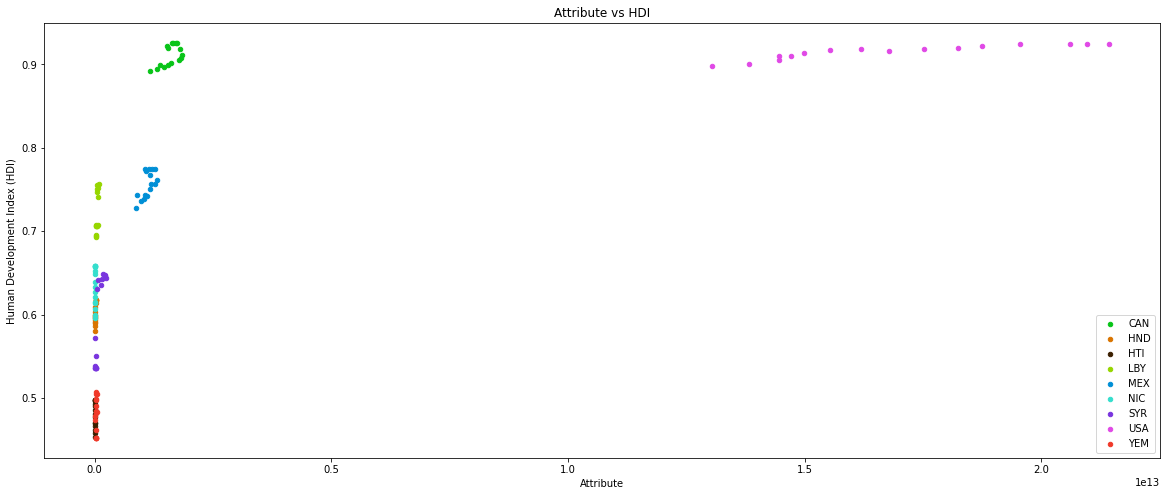

life_expectancy_at_birth


Text(0.5, 0, 'Attribute')

Text(0, 0.5, 'Human Development Index (HDI)')

Text(0.5, 1.0, 'Attribute vs HDI')

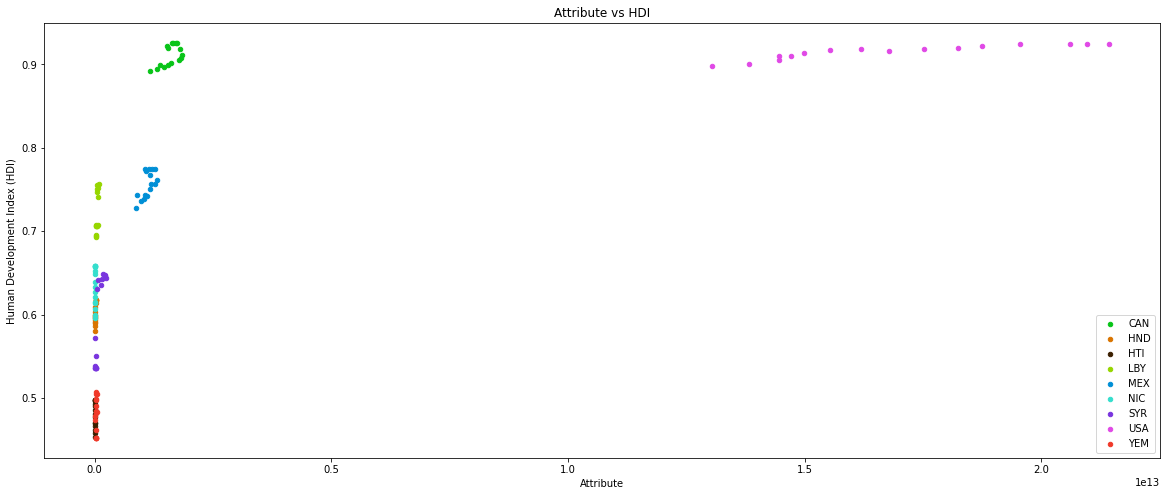

co2_emissions_metric_tons_per_capita


Text(0.5, 0, 'Attribute')

Text(0, 0.5, 'Human Development Index (HDI)')

Text(0.5, 1.0, 'Attribute vs HDI')

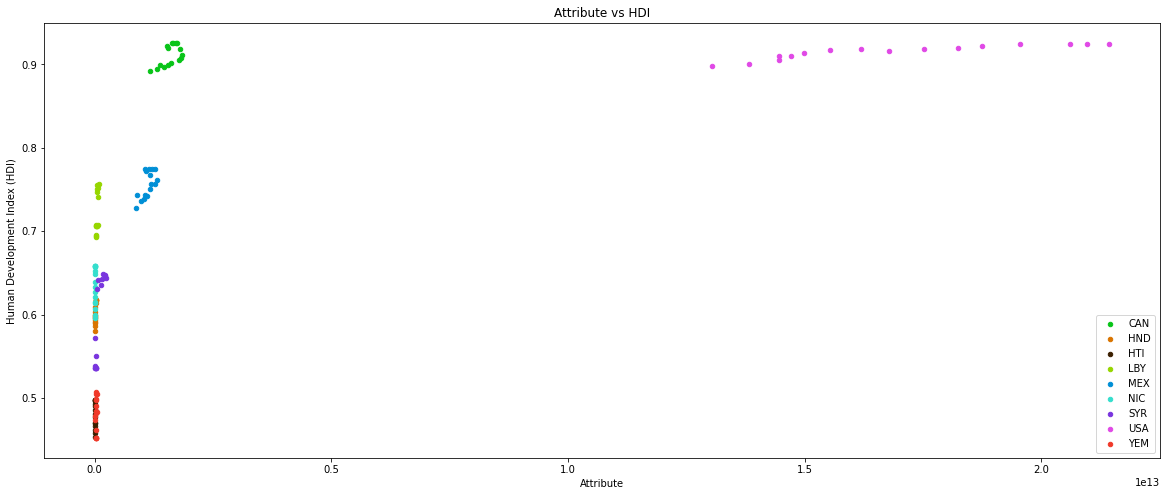

In [65]:
attributes = {
  'gdp': 'key_indicators',
  'death_rate_per_1000': 'key_indicators',
  'birth_rate_per_1000': 'key_indicators',
  'life_expectancy_at_birth': 'key_indicators',
  'co2_emissions_metric_tons_per_capita': 'climate'
}

colorKey = {
  "CAN": "#08c418",
  "HND": "#d97400",
  "HTI": "#3b1f00",
  "LBY": "#96d600",
  "MEX": "#008fd6",
  "NIC": "#35decd",
  "SYR": "#7935de",
  "USA": "#e049e6",
  "YEM": "#f03929"
}

for attribute in attributes:
  name = attribute
  table = pd.read_csv("data/"+attributes[name])

  merged = keyIndicators.merge(table, on=['country_code', 'yr'])

  print(name)

  # Draw the scatter plots country by country  
  fig, ax = plt.subplots(figsize=(20, 8))
  for key, group in keyIndicators.groupby(['country_code']):
    ax = group.plot(loglog=False, color=colorKey[key], ax=ax, kind='scatter', x='gdp', y='human_development_index', label=str(key)) # increase clarity of label    

  # The labels are used to define the legend. Move the legend to the upper right.    
  plt.legend(loc='lower right')

  # Define the name of the axes.
  plt.xlabel("Attribute")
  plt.ylabel("Human Development Index (HDI)")

  # Title the figure.
  plt.title("Attribute vs HDI")

  # Plot the figure
  plt.show()

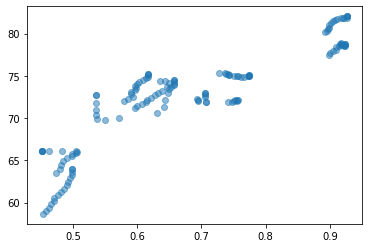

In [20]:

plt.scatter(keyIndicators['human_development_index'], keyIndicators['life_expectancy_at_birth'], alpha=0.5)
plt.show()


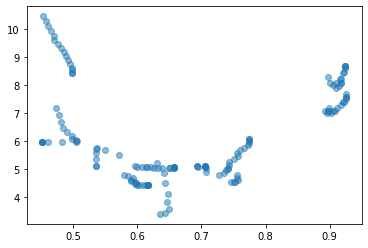

In [7]:
plt.scatter(keyIndicators['human_development_index'], keyIndicators['death_rate_per_1000'], alpha=0.5)
plt.show()

In [ ]:


plt.scatter(keyIndicators['human_development_index'], keyIndicators[], alpha=0.5)
plt.show()

In [19]:
# combine key indicators and health dataframes

health = pd.read_csv("data/health")

health_key_indicators = keyIndicators.merge(health, on=['country_code', 'yr'])

health_key_indicators.head()

,indicator_key,country_code,yr,human_development_index,gdp,death_rate_per_1000,birth_rate_per_1000,life_expectancy_at_birth,health_key,hospital_beds_per_1000,...,mortality_rate_adult_male_per_1000,mortality_rate_infant_per_1000,mortality_rate_infant_female_per_1000,mortality_rate_infant_male_per_1000,number_of_stillbirths,prevalence_of_overweight_adults_percentage,prevalence_of_overweight_male_adults_percentage,prevalence_of_anemia_children_6_to_59_months,prevalence_of_anemia_women_15_to_49_years_percentage,prevalence_of_overweight_female_adults_percentage
0,1,CAN,2005,0.892,1173108598779,7.1,10.6,80.192683,600,3.10,...,94.329,5.2,4.8,5.6,1037,58.6,64.4,10.3,8.7,52.8
1,2,CAN,2006,0.895,1319264809591,7.0,10.9,80.343902,601,3.02,...,91.806,5.2,4.8,5.6,1083,59.2,65.0,10.3,8.7,53.4
2,3,CAN,2007,0.897,1468820407783,7.1,11.2,80.543902,602,2.96,...,91.762,5.1,4.7,5.5,1129,59.7,65.5,10.3,8.7,53.9
3,4,CAN,2008,0.899,1552989690722,7.2,11.3,80.695122,603,2.85,...,89.926,5.1,4.7,5.5,1138,60.2,66.0,10.3,8.7,54.4
4,5,CAN,2009,0.899,1374625142157,7.1,11.3,80.995122,604,2.80,...,87.745,5.0,4.6,5.4,1126,60.7,66.5,10.4,8.7,54.9


In [171]:
#print(len(health_key_indicators.index))
#print(health_key_indicators.columns)

labels=keyIndicators['country_code'].unique().tolist()
print(labels)

['CAN', 'HND', 'HTI', 'LBY', 'MEX', 'NIC', 'SYR', 'USA', 'YEM']


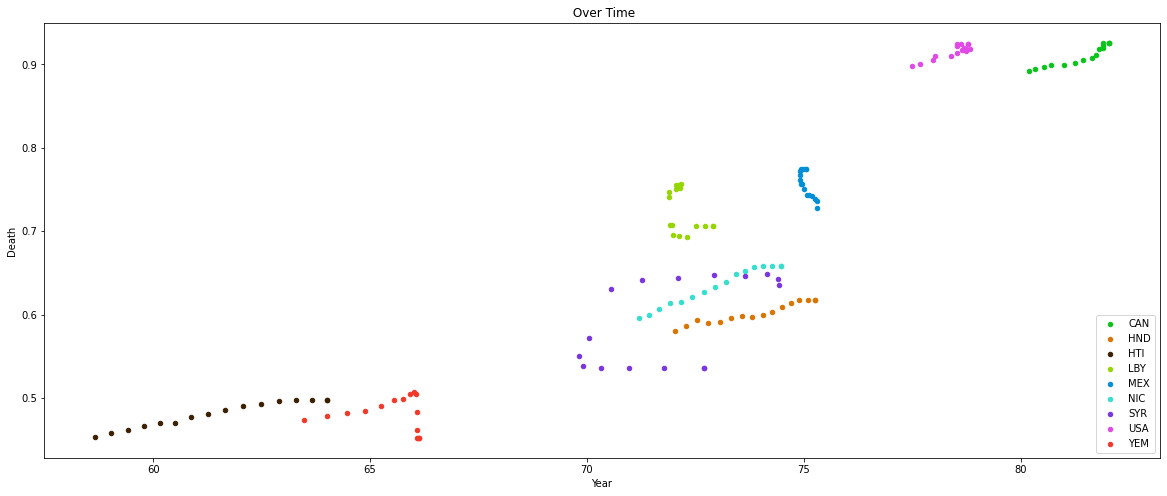

In [47]:
fig, ax = plt.subplots(figsize=(20, 8))

for key, group in health_key_indicators.groupby(['country_code']):
  #  if (key == 'CAN' or key == 'USA'):
  #     continue
    ax = group.plot(loglog=False, color=colorKey[key], ax=ax, kind='scatter', x='life_expectancy_at_birth', y='human_development_index', label=str(key)) # increase clarity of label    

# The labels are used to define the legend. Move the legend to the upper right.    
plt.legend(loc='lower right')

# Define the name of the axes.
plt.xlabel("Year")
plt.ylabel("Death")

# Title the figure.
plt.title(" Over Time")

# Plot the figure
plt.show()

In [10]:
# combine key indicators and education dataframe

education = pd.read_csv("data/education")

education_key_indicators = keyIndicators.merge(education, on=['country_code', 'yr'])


In [12]:
# print out the number of missing values per column

education_key_indicators.isnull().sum().sort_values(ascending=False)

literacy_rate_adult_female_percentage                  80
literacy_rate_youth_male_percentage                    80
literacy_rate_youth_total_percentage                   80
literacy_rate_adult_total_percentage                   80
literacy_rate_adult_male_percentage                    80
school_enrollment_primary_percentage_male_net          65
school_enrollment_primary_percentage_female_net        65
primary_education_completed_percentage                 48
school_enrollment_tertiary_percentage_gross            48
school_enrollment_tertiary_percentage_female_gross     48
public_spending_education_percentage_of_gdp            32
school_enrollment_secondary_percentage_male_net        32
school_enrollment_secondary_percentage_female_net      32
school_enrollment_secondary_percentage_net             32
school_enrollment_primary_percentage_net               32
school_enrollment_secondary_percentage_male_gross      30
school_enrollment_secondary_percentage_female_gross    30
school_enrollm

In [63]:
# school_enrollment_primary_percentage_gross vs hdi
# school_enrollment_secondary_percentage_gross vs hdi

# hdi
# very high (0.8 - 1.0)
# high (0.7 - 0.79)
# medium (0.55 - 0.70)
# low (0.00 - 0.54)


education_key_indicators['hdi_group'] = education_key_indicators['human_development_index']

for i in range(len(education_key_indicators['hdi_group'])):
    if education_key_indicators['hdi_group'][i] >= 0.8:
        education_key_indicators['hdi_group'] = 'very high'
    elif education_key_indicators['hdi_group'][i] >= 0.7 and education_key_indicators['hdi_group'][i] <= 0.79:
        education_key_indicators['hdi_group'] = 'high'
    elif education_key_indicators['hdi_group'][i] >= 0.55 and education_key_indicators['hdi_group'][i] <= 0.69:
        education_key_indicators['hdi_group'] = 'medium'
    else:
        



#education_key_indicators['school_enrollment_primary_percentage_gross'].plot(kind='box')

#plt.boxplot(x=education_key_indicators['school_enrollment_primary_percentage_gross'])


In [36]:
# combine key indicators and population dataframe

population = pd.read_csv("data/population")

population_key_indicators = keyIndicators.merge(population, on=['country_code', 'yr'])

# print out the number of missing values per column

population_key_indicators.isnull().sum().sort_values(ascending=False)


percent_rural_poverty_headcount_ratio_at_national_poverty_line    144
percent_urban_poverty_headcount_ratio_at_national_poverty_line    144
percent_poverty_headcount_ratio_at_national_poverty_line          128
net_migration                                                     117
life_expectancy_at_birth_for_females                                9
life_expectancy_at_birth_for_males                                  9
indicator_key                                                       0
percent_population_ages_25_to_29_female                             0
percent_population_ages_25_to_29_male                               0
percent_population_ages_30_to_34_female                             0
percent_population_ages_30_to_34_male                               0
percent_population_ages_35_to_39_female                             0
percent_population_ages_35_to_39_male                               0
percent_population_ages_40_to_44_female                             0
percent_population_a